In [1]:
#載入data
from finlab.data import Data
data = Data()
#忽略錯誤訊息
import warnings
warnings.filterwarnings("ignore")
#月轉季函數
def toSeasonal(df):
    season4 = df[df.index.month == 3]
    season1 = df[df.index.month == 5]
    season2 = df[df.index.month == 8]
    season3 = df[df.index.month == 11]

    season1.index = season1.index.year
    season2.index = season2.index.year
    season3.index = season3.index.year
    season4.index = season4.index.year - 1

    newseason1 = season1
    newseason2 = season2 - season1.reindex_like(season2)
    newseason3 = season3 - season2.reindex_like(season3)
    newseason4 = season4 - season3.reindex_like(season4)

    newseason1.index = pd.to_datetime(newseason1.index.astype(str) + '-05-15')
    newseason2.index = pd.to_datetime(newseason2.index.astype(str) + '-08-14')
    newseason3.index = pd.to_datetime(newseason3.index.astype(str) + '-11-14')
    newseason4.index = pd.to_datetime((newseason4.index + 1).astype(str) + '-03-31')

    return newseason1.append(newseason2).append(newseason3).append(newseason4).sort_index()

In [2]:
#設定影響股價的因子
def Setfeature(data):

    #特徵 1 市值=總股數*股價=(股本*1000)/10 * 股價
    股本 = data.get('股本合計', 1)
    price = data.get('收盤價', 200)
    當天股價 = price[:股本.index[-1]].iloc[-1]
    當天股本 = 股本.iloc[-1]
    市值 = 當天股本 * 當天股價 / 10 * 1000

    #特徵 2 自由現金流 = 最近四季的平均自由現金流   
    df1 = toSeasonal(data.get('投資活動之淨現金流入（流出）', 5))
    df2 = toSeasonal(data.get('營業活動之淨現金流入（流出）', 5))
    自由現金流 = (df1 + df2).iloc[-4:].mean()

    #特徵3 股東權益報酬率 = 稅後淨利/權益總計      
    稅後淨利 = data.get('本期淨利（淨損）', 1)
    權益總計 = data.get('權益總計', 1)
    權益總額 = data.get('權益總額', 1)
    權益總計.fillna(權益總額, inplace=True)
    股東權益報酬率 = 稅後淨利.iloc[-1] / 權益總計.iloc[-1]

    #特徵4 營業利益成長率 = [(最新一季營業利益/去年同期營業利益)-1] * 100   
    營業利益 = data.get('營業利益（損失）', 5)
    營業利益成長率 = (營業利益.iloc[-1] / 營業利益.iloc[-5] - 1) * 100

    #特徵5 市值營收比 = 市值/當季營收(最近四個月營收的總和)   
    當月營收 = data.get('當月營收', 4) * 1000
    當季營收 = 當月營收.iloc[-4:].sum()
    市值營收比 = 市值 / 當季營收

    #特徵6 RSV = (股價-最近150日最小值) / (最近150日最大值-最近150日最小值) 
    RSV = (price.iloc[-1] - price.iloc[-150:].min()) / (price.iloc[-150:].max() - price.iloc[-150:].min())
    
    #特徵7 本益比 = 本益比低於12算便宜
    本益比 = data.get('本益比',1).iloc[-1]
    
    #特徵8 股價淨值比 = 股價/淨值
    淨值 = data.get('資產總計',1) - data.get('負債總計',1)
    每股淨值 = 淨值/股本
    股價淨值比 = (當天股價/每股淨值)/10
    股價淨值比 = 股價淨值比.iloc[-1]
    
    
    return [當天股價,市值,自由現金流,股東權益報酬率,營業利益成長率,市值營收比,RSV,本益比,股價淨值比]

In [3]:
#定義策略
import pandas as pd
import numpy as np
def strategy(data):

    #準備資料
    df = pd.DataFrame()
    temp = Setfeature(data)
    
    df['f0'] = temp[1]#市值
    df['f1'] = temp[2]#自由現金流
    df['f2'] = temp[3]#股東權益報酬率
    df['f3'] = temp[4]#營業利益成長率
    df['f4'] = temp[5]#市值營收比
    df['f5'] = temp[6]#RSV
    df['f6'] = temp[7]#本益比
    df['f7'] = temp[8]#股價淨值比

    df = df.replace([np.inf, -np.inf], np.nan)#去除極值
    df = df.dropna()#去除空值
    
    c1 = df['f0'] < 1e10
    c2 = df['f1'] > 0
    c3 = df['f2'] > 0.03
    c4 = df['f3'] > 0.05
    c5 = df['f4'] < 3
    c6 = df['f5'] > 0.55
    c7 = df['f6'] < 12
    c8 = df['f7'] < 3
    
    select_stock = c1 & c2 & c3 & c4 & c5 & c6 & c7 & c8
    
    return select_stock[select_stock]

2015-01-01 - 2015-04-01 報酬率: 0.00 % nstock 0
2015-04-01 - 2015-06-30 報酬率: 0.00 % nstock 0
2015-06-30 - 2015-09-28 報酬率: 16.78 % nstock 2
2015-09-28 - 2015-12-27 報酬率: 17.15 % nstock 4
2015-12-27 - 2016-03-26 報酬率: 16.68 % nstock 10
2016-03-26 - 2016-06-24 報酬率: 1.94 % nstock 20
2016-06-24 - 2016-09-22 報酬率: 11.08 % nstock 10
2016-09-22 - 2016-12-21 報酬率: 6.31 % nstock 16
2016-12-21 - 2017-03-21 報酬率: 14.78 % nstock 15
2017-03-21 - 2017-06-19 報酬率: 5.95 % nstock 14
2017-06-19 - 2017-09-17 報酬率: 9.34 % nstock 4
2017-09-17 - 2017-12-16 報酬率: 3.60 % nstock 4
2017-12-16 - 2018-03-16 報酬率: 6.04 % nstock 12
2018-03-16 - 2018-06-14 報酬率: 6.12 % nstock 9
2018-06-14 - 2018-09-12 報酬率: -11.11 % nstock 5
2018-09-12 - 2018-12-11 報酬率: -6.05 % nstock 7
2018-12-11 - 2019-03-11 報酬率: 11.20 % nstock 6
2019-03-11 - 2019-06-09 報酬率: 11.58 % nstock 9
每次換手最大報酬 : 17.15 ％
每次換手最少報酬 : -11.11 ％


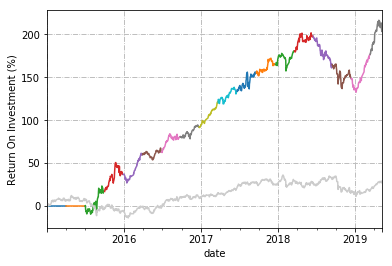

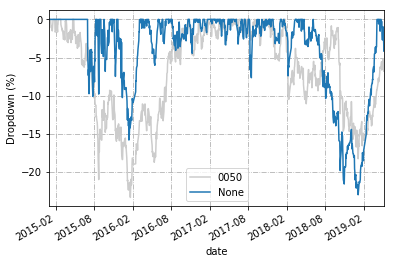

(2015-01-02    1.000000
 2015-01-03    1.000000
 2015-01-04    1.000000
 2015-01-05    1.000000
 2015-01-06    1.000000
 2015-01-07    1.000000
 2015-01-08    1.000000
 2015-01-09    1.000000
 2015-01-10    1.000000
 2015-01-11    1.000000
 2015-01-12    1.000000
 2015-01-13    1.000000
 2015-01-14    1.000000
 2015-01-15    1.000000
 2015-01-16    1.000000
 2015-01-17    1.000000
 2015-01-18    1.000000
 2015-01-19    1.000000
 2015-01-20    1.000000
 2015-01-21    1.000000
 2015-01-22    1.000000
 2015-01-23    1.000000
 2015-01-24    1.000000
 2015-01-25    1.000000
 2015-01-26    1.000000
 2015-01-27    1.000000
 2015-01-28    1.000000
 2015-01-29    1.000000
 2015-01-30    1.000000
 2015-01-31    1.000000
                 ...   
 2019-03-22    2.882902
 2019-03-25    2.885016
 2019-03-26    2.903392
 2019-03-27    2.910087
 2019-03-28    2.887219
 2019-03-29    2.909632
 2019-04-01    2.910443
 2019-04-02    2.979102
 2019-04-03    3.018810
 2019-04-08    3.041255
 2019-04-09    3

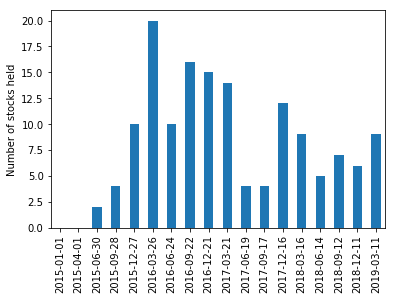

In [4]:
from finlab.backtest import backtest
from finlab.data import Data
import datetime

mystrategy = strategy

%matplotlib inline
data = Data()
backtest(datetime.date(2015,1,1), datetime.date(2019,5,7), 90, mystrategy, data)

In [5]:
from finlab.data import Data
data = Data()
data.date=datetime.datetime.now()
stock_list=strategy(data).index.tolist()
stock_list

['2020', '2546', '2816', '2852', '3535', '4927']

In [6]:
df = pd.DataFrame()
temp = Setfeature(data)
df['市值'] = temp[1]#市值
df['自由現金流'] = temp[2]#自由現金流
df['股東權益報酬率'] = temp[3]#股東權益報酬率
df['營業利益成長率'] = temp[4]#營業利益成長率
df['市值營收比'] = temp[5]#市值營收比
df['RSV'] = temp[6]#RSV
df['本益比'] = temp[7]#本益比
df['股價淨值比'] = temp[8]#股價淨值比
df = df.replace([np.inf, -np.inf], np.nan)#去除極值
df = df.dropna()#去除空值
df=df.reset_index()
df.head()

,stock_id,市值,自由現金流,股東權益報酬率,營業利益成長率,市值營收比,RSV,本益比,股價淨值比
0,1101,2.216115e+11,-3075227.25,0.020128,8.219660,7.179448,0.921053,10.11,1.054510
1,1102,1.374832e+11,-1770385.00,0.022956,41.292230,4.940921,1.000000,12.12,0.828361
2,1103,1.185414e+10,-102912.25,0.006871,10.499506,23.487780,1.000000,14.81,0.548193
3,1104,1.277806e+10,55627.00,0.008587,-79.508512,7.955024,0.388889,10.38,0.700667
4,1108,2.833166e+09,-115074.50,-0.007066,-23.752639,2.446220,0.021505,0.00,0.672350


In [12]:
low_level={}
median_level={}
high_level={}
for i in df.columns.tolist()[1:]:
    low_level[i]=df[i].quantile(0.25)
    median_level[i]=df[i].quantile(0.5)
    high_level[i]=df[i].quantile(0.75)
print(low_level)
print(median_level)
print(high_level)

{'營業利益成長率': -67.5993513089137, '市值': 2483027091.2500005, '市值營收比': 2.048592873716654, '本益比': 7.4825, '股東權益報酬率': 0.0011606901373642112, 'RSV': 0.235442356625563, '自由現金流': -45446.75, '股價淨值比': 0.7844525846892566}
{'營業利益成長率': -15.631107158883623, '市值': 5751672225.0, '市值營收比': 3.475890150535416, '本益比': 13.184999999999999, '股東權益報酬率': 0.012937804321485849, 'RSV': 0.48756142506142514, '自由現金流': 28149.5, '股價淨值比': 1.1358825510051496}
{'營業利益成長率': 22.71437960605664, '市值': 13876736500.0, '市值營收比': 6.158298337540723, '本益比': 21.150000000000002, '股東權益報酬率': 0.026904514328356097, 'RSV': 0.7294619746086526, '自由現金流': 168362.5, '股價淨值比': 1.7427073075251815}


In [16]:
def transform(df_column):
    col_name=df_column.name
    return df_column.apply(lambda x:4 if x>high_level[col_name]
                             else 3 if high_level[col_name]>x>median_level[col_name]
                             else 2 if median_level[col_name]>x>low_level[col_name]
                             else 1)
    

In [17]:
for col in df.columns[1:].tolist():
    df[col]=transform(df[col])

In [18]:
df.head()

,stock_id,市值,自由現金流,股東權益報酬率,營業利益成長率,市值營收比,RSV,本益比,股價淨值比
0,1101,4,1,3,3,4,4,2,2
1,1102,4,1,3,4,3,4,2,2
2,1103,3,1,2,3,4,4,3,1
3,1104,3,3,2,1,4,2,2,1
4,1108,2,1,1,2,2,1,1,1


In [19]:
my_stock = []
for sid in stock_list:
    my_stock.append(df[df['stock_id']==sid])
my_stock=pd.concat(my_stock,axis=0)
my_stock

,stock_id,市值,自由現金流,股東權益報酬率,營業利益成長率,市值營收比,RSV,本益比,股價淨值比
208,2020,2,3,4,4,2,4,2,3
409,2546,2,4,4,4,1,4,2,3
448,2816,2,2,4,4,1,3,1,2
454,2852,2,2,4,4,2,3,1,1
565,3535,2,3,4,4,2,4,2,4
643,4927,3,4,4,4,2,4,2,3


<font size=5>繪製雷達圖</font>

In [20]:
from matplotlib.font_manager import FontProperties

import matplotlib.pyplot as plt
plt.rcParams['font.sans-serif'] = ['Microsoft JhengHei'] 
plt.rcParams['axes.unicode_minus'] = False

In [21]:
def result_pic(result):
    labels = result.columns[1:].tolist()
    kinds = result.stock_id.tolist()

    # 由于在雷达图中，要保证数据闭合，这里就再添加L列，并转换为 np.ndarray
    result = pd.concat([result.iloc[:,1:], result[['市值']]], axis=1)
    centers = np.array(result.iloc[:,:])

    # 分割圆周长，并让其闭合
    n = len(labels)
    angle = np.linspace(0, 2 * np.pi, n, endpoint=False)
    angle = np.concatenate((angle, [angle[0]]))

    # 画线
    for i in range(len(kinds)):
        fig = plt.figure(figsize=(5,5))
        ax = fig.add_subplot(111,polar=True)
        ax.plot(angle, centers[i], linewidth=2, label=kinds[i])
        ax.fill(angle, centers[i])  # 填充底色
        ax.set_thetagrids(angle * 180 / np.pi, labels)
        plt.title(kinds[i])
        plt.show()

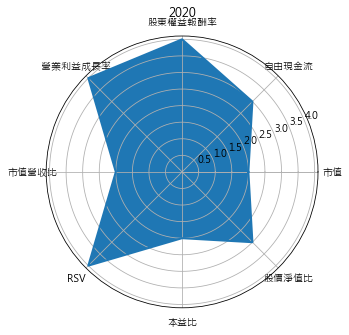

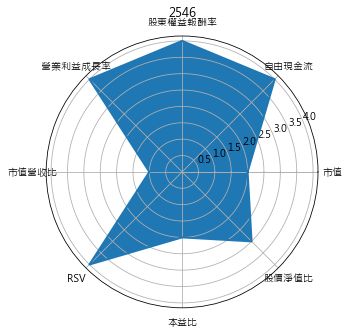

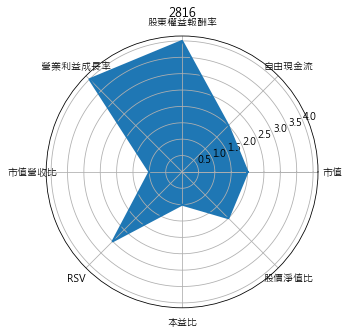

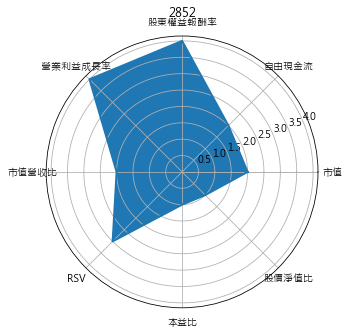

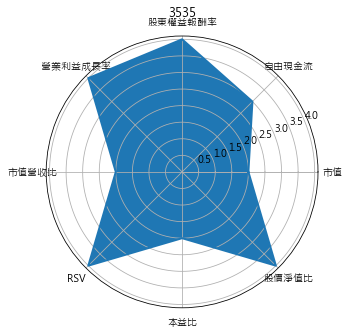

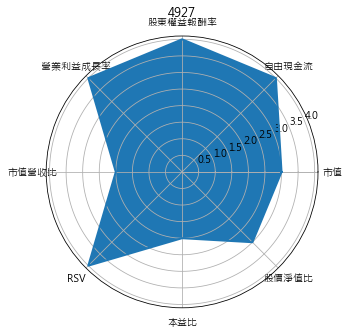

In [22]:
%matplotlib inline
import matplotlib.pyplot as plt
result_pic(my_stock)